# 3. Modeling

In [383]:
import numpy as np
import pandas as 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

import random
import os
random.seed(42)

In [1302]:
new_df = pd.read_csv(os.path.join("..","..","data",'YN_final_df.csv'))
new_df.head()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr
0,788542,마르코 폴로,EAT,5.0,20180314,0,0,1,20,0.05,3.95,4.363636,11,14256,1,서울 강남구 삼성동 159-1 트레이드타워 52층
1,788542,마르코 폴로,EAT,4.0,20171207,0,0,1,20,0.05,3.95,4.000000,6,722,1,서울 강남구 삼성동 159-1 트레이드타워 52층
2,788542,마르코 폴로,EAT,5.0,20161110,0,0,0,20,0.05,3.95,5.000000,1,30372,1,서울 강남구 삼성동 159-1 트레이드타워 52층
3,788542,마르코 폴로,EAT,3.0,20160611,0,0,0,20,0.05,3.95,4.250000,4,2116,1,서울 강남구 삼성동 159-1 트레이드타워 52층
4,788542,마르코 폴로,EAT,4.0,20151204,0,0,1,20,0.05,3.95,4.095238,42,3208,1,서울 강남구 삼성동 159-1 트레이드타워 52층


### 로컬 / 글로벌 데이터 분리

In [1303]:
# 로컬 / 글로벌 데이터 분리
local_df = new_df.loc[new_df['is_local']==1]
global_df = new_df.loc[new_df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (459903, 16) global_df shape : (93722, 16)


In [1304]:
'''
체인을 빼도ㅍ성능 나빠.... 
차라리 장소의 다양성을 위해 + 글로벌 데이터 추천 결과가 좋으므로
글로벌 데이터 추가해서 전체 중에서
체인 및 손수 전처리 체인 제거
'''

local_df = new_df.copy()
local_df.shape

(553625, 16)

In [1305]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']
print(local_df_acm.shape, local_df_eat.shape)

(57122, 16) (496503, 16)


In [1306]:
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df_eat.shape

local_df = pd.concat([local_df_acm, local_df_eat])
local_df.shape

(305395, 16)

In [1307]:
# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]
local_df.shape

(237052, 16)

In [1308]:
fch_lst = ['써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관'
]
fch_idx = local_df[local_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = local_df[local_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()
print(len(fch_idx))
print(len(idx))

1527
41784


In [1309]:
for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)
        
print(len(fch_idx))

42382


In [1310]:
print(local_df.shape[0])
local_df = local_df.drop(fch_idx)
print(local_df.shape[0])

237052
194670


In [1311]:
local_df['lw'] = local_df['is_local'].apply(lambda x: 1 if x==0 else 0)
local_df['lw'] = local_df['lw']*5
local_df.head()

,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr,lw
81114,1011796922,호텔더디자이너스동대문,ACM,5.000000,20191216,0,0,1,1,0.0,5.000000,4.417995,105,42122,1,서울특별시 중구 쌍림동 266-2,0
81115,37903636,아만티호텔서울,ACM,4.666667,20190722,0,0,1,3,0.0,4.666667,4.417995,105,42122,1,서울특별시 마포구 월드컵북로 31,0
81155,13217405,코트야드 메리어트 서울 타임스퀘어,ACM,4.270833,20190621,0,0,1,24,0.0,4.270833,4.414649,40,101654,1,서울특별시 영등포구 영중로 15 타임스퀘어,0
81659,20315170,스탠포드호텔코리아,ACM,4.184211,20191227,0,0,1,19,0.0,4.184211,4.395100,33,24205,1,서울특별시 마포구 상암동 1587,0
81660,20315170,스탠포드호텔코리아,ACM,4.184211,20191209,0,0,1,19,0.0,4.184211,4.395100,33,24205,1,서울특별시 마포구 상암동 1587,0


In [1329]:
local_df.to_csv(os.path.join("..","realtime_model",'local_df.csv'), index=False)


In [1312]:
# fch_lst = ['써브웨이', '맥도날드','노브랜드버거','바르다김선생',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이']
# fch_idx = global_df[global_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
# len(fch_idx)

# print(global_df.shape[0])
# global_df = global_df.drop(fch_idx)
# print(global_df.shape[0])

In [1313]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: # np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    # encoded_d = [vocab[i] for i in test[column]]
    
    return encoded, num, vocab

In [1314]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12 = vects 
    z = tf.concat([a1,a2],axis=2)
    z = tf.concat([z,a3],axis=2)
    z = tf.concat([z,a4],axis=2)
    z = tf.concat([z,a5],axis=2)
    z = tf.concat([z,a6],axis=2)
    z = tf.concat([z,a7],axis=2)
    z = tf.concat([z,a8],axis=2)
    z = tf.concat([z,a9],axis=2)
    z = tf.concat([z,a10],axis=2)
    z = tf.concat([z,a11],axis=2)
    z = tf.concat([z,a12],axis=2)
    return z

def sum_layer(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12 = vects
    z = tf.add(a1,a2)
    z = tf.add(z,a3) 
    z = tf.add(z,a4)
    z = tf.add(z,a5)
    z = tf.add(z,a6)
    z = tf.add(z,a7)
    z = tf.add(z,a8)
    z = tf.add(z,a9)
    z = tf.add(z,a10)
    z = tf.add(z,a11)
    z = tf.add([z,a12],axis=2)
    return z 

## 1. local_modeling

In [1315]:
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 

encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 

encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 

encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', local_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', local_df) 

encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 

encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_lw,  num_lw, vocab_lw = get_data('lw', local_df) 


# Input Data

In [1316]:
import tensorflow as tf 
print(tf.__version__)

2.1.0


In [1317]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 

users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 

user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 

locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')

createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')

fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')
lw = Input(shape=(1,), dtype='int64', name = 'lw')

In [1318]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)

FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  

FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)

FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   

FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)

FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

FM_lw = Embedding(input_dim = num_lw, output_dim = n_factors, 
                              name = 'FM_lw', input_length=1)(lw)

In [1319]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)

FM_lw_latent = Flatten()(FM_lw)
FM_lw_latent = Lambda(trans_mul)(FM_lw_latent)

FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent, FM_lw_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [1320]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent, FM_lw_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

In [1321]:
# ! pip install pydot

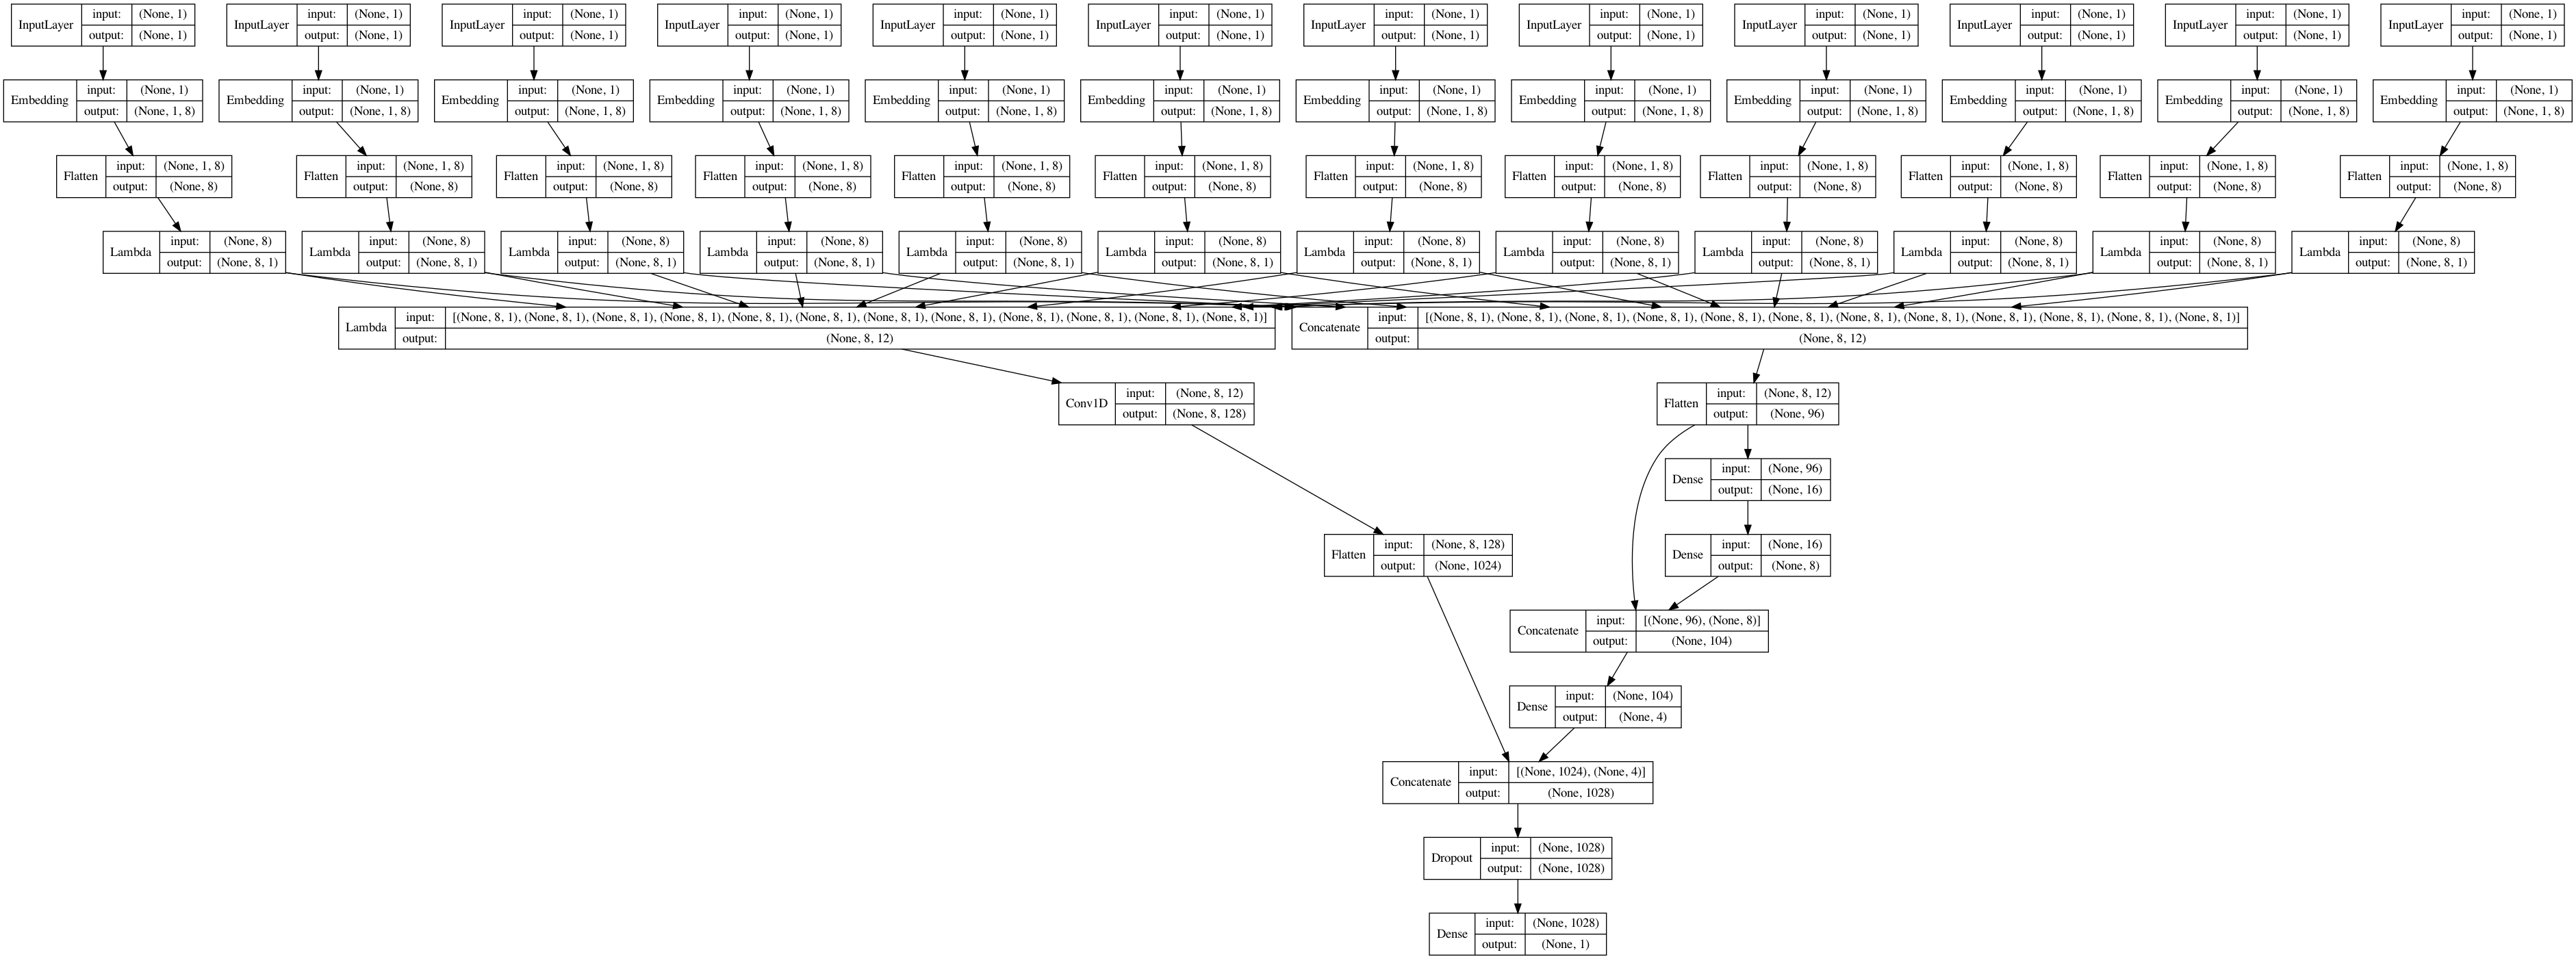

In [1322]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating, lw], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 193696 samples, validate on 974 samples
Epoch 1/20
193696/193696 [==============================] - 6s 31us/step - loss: 19.4126 - auc_21: 0.0000e+00 - val_loss: 18.7572 - val_auc_21: 0.0000e+00
Epoch 2/20
193696/193696 [==============================] - 5s 26us/step - loss: 17.3294 - auc_21: 0.0000e+00 - val_loss: 16.0947 - val_auc_21: 0.0000e+00
Epoch 3/20
193696/193696 [==============================] - 5s 26us/step - loss: 14.2474 - auc_21: 0.0000e+00 - val_loss: 12.4378 - val_auc_21: 0.0000e+00
Epoch 4/20
193696/193696 [==============================] - 5s 28us/step - loss: 10.3358 - auc_21: 0.0000e+00 - val_loss: 8.1392 - val_auc_21: 0.0000e+00
Epoch 5/20
193696/193696 [==============================] - 5s 25us/step - loss: 6.1047 - auc_21: 0.0000e+00 - val_loss: 3.9027 - val_auc_21: 0.0000e+00
Epoch 6/20
193696/193696 [==============================] - 4s 23us/step - loss: 2.3963 - auc_21: 0.0000e+00 - val_loss: 0.8067 - val_auc_21: 0.0000e+00
Epoch 7/20
193696/193696 [

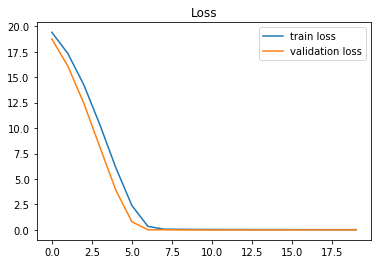

In [1323]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating, encoded_lw],
                    y=local_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [1324]:
# 모델 저장하기 
model.save_weights(os.path.join("..","realtime_model",'wnd_local_model2.h5'))

model_json = model.to_json()
with open(os.path.join("..","realtime_model","wnd_local_model2.json"), "w") as json_file : 
    json_file.write(model_json)
    
print("Saved model to disk")

Saved model to disk


# item 유사도 반환

In [1325]:
# 모델 불러오기 
from keras.models import model_from_json 
json_file = open(os.path.join("..","realtime_model","wnd_local_model2.json"), "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

loaded_model.load_weights(os.path.join("..","realtime_model","wnd_local_model2.h5"))
print("Loaded model from disk")

Loaded model from disk


In [1332]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [1342]:
vec = latent_to_vec('FM_locationId', loaded_model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating, encoded_lw])

In [1343]:
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1011796922,-0.031066,-0.034192,-0.034994,-0.029129,-0.029983,-0.043482,-0.046158,-0.040265
37903636,-0.040485,-0.039773,-0.045330,-0.042388,-0.046866,-0.046284,-0.042195,-0.041556
13217405,-0.035272,-0.035918,-0.035505,-0.031587,-0.033636,-0.032905,-0.034658,-0.033345
20315170,0.033603,-0.037037,-0.058592,-0.044101,0.033603,-0.020770,-0.093937,-0.019249
20509127,-0.028932,-0.040340,-0.033139,-0.055224,-0.048970,-0.041472,-0.032777,-0.038457
...,...,...,...,...,...,...,...,...
9129031,-0.005318,-0.005703,-0.005366,-0.009624,0.007591,-0.002569,-0.001280,-0.001716
12816960,-0.012766,-0.011012,-0.015431,-0.010594,-0.006183,-0.012430,-0.006460,-0.009152
16656485,0.002625,-0.007622,-0.000420,-0.003831,-0.004219,0.002044,0.003565,0.001960


In [1348]:
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
1011796922,-0.031066,-0.034192,-0.034994,-0.029129,-0.029983,-0.043482,-0.046158,-0.040265
37903636,-0.040485,-0.039773,-0.045330,-0.042388,-0.046866,-0.046284,-0.042195,-0.041556
13217405,-0.035272,-0.035918,-0.035505,-0.031587,-0.033636,-0.032905,-0.034658,-0.033345
20315170,0.033603,-0.037037,-0.058592,-0.044101,0.033603,-0.020770,-0.093937,-0.019249
20509127,-0.028932,-0.040340,-0.033139,-0.055224,-0.048970,-0.041472,-0.032777,-0.038457
...,...,...,...,...,...,...,...,...
9129031,-0.005318,-0.005703,-0.005366,-0.009624,0.007591,-0.002569,-0.001280,-0.001716
12816960,-0.012766,-0.011012,-0.015431,-0.010594,-0.006183,-0.012430,-0.006460,-0.009152
16656485,0.002625,-0.007622,-0.000420,-0.003831,-0.004219,0.002044,0.003565,0.001960


In [1349]:
vec.to_csv(os.path.join("..","realtime_model",'wnd_local_vec.csv'))#, index=False)


In [1355]:
vecs = pd.read_csv(os.path.join("..","realtime_model",'wnd_local_vec.csv'))
vecs

,locationId,0,1,2,3,4,5,6,7
0,1011796922,-0.031066,-0.034192,-0.034994,-0.029129,-0.029983,-0.043482,-0.046158,-0.040265
1,37903636,-0.040485,-0.039773,-0.045330,-0.042388,-0.046866,-0.046284,-0.042195,-0.041556
2,13217405,-0.035272,-0.035918,-0.035505,-0.031587,-0.033636,-0.032905,-0.034658,-0.033345
3,20315170,0.033603,-0.037037,-0.058592,-0.044101,0.033603,-0.020770,-0.093937,-0.019249
4,20509127,-0.028932,-0.040340,-0.033139,-0.055224,-0.048970,-0.041472,-0.032777,-0.038457
...,...,...,...,...,...,...,...,...,...
5596,9129031,-0.005318,-0.005703,-0.005366,-0.009624,0.007591,-0.002569,-0.001280,-0.001716
5597,12816960,-0.012766,-0.011012,-0.015431,-0.010594,-0.006183,-0.012430,-0.006460,-0.009152
5598,16656485,0.002625,-0.007622,-0.000420,-0.003831,-0.004219,0.002044,0.003565,0.001960
5599,4030185,-0.008957,-0.005460,0.001805,-0.008903,0.004681,-0.009067,0.001032,-0.004306


In [1200]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [ ]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [710]:
sim_item(vec, local_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 긴자료코 숙대점
  주소 서울특별시 용산구 청파동3가 107-1
top 2 명랑핫도그 잠실장미점
  주소 서울특별시 송파구 신천동 7 장미아파트 에이상가
top 3 101번지남산돈까스
  주소 서울특별시 강남구 역삼동 689-16
top 4 서연황소곱창
  주소 서울특별시 서대문구 창천동 52-119
top 5 현대칼국수
  주소 서울특별시 중구 태평로2가 69-3 청남빌딩
top 6 귀일교자 방배점
  주소 서울특별시 서초구 방배동 911-22
top 7 돈까스참잘하는집
  주소 서울특별시 동작구 신대방동 395-66 보라매삼성쉐르빌
top 8 돈까스의집
  주소 서울특별시 송파구 삼전동 1-4 아카데미빌딩
top 9 카페밸런스
  주소 서울특별시 송파구 잠실동 22-6 리센츠
top 10 스패뉴
  주소 서울특별시 중구 태평로2가 362-1


In [711]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [712]:
sim_item(vec, local_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 카페게이트 구산사거리점
  주소 서울특별시 은평구 갈현동 498-4 구산빌딩
top 2 하나텐
  주소 서울특별시 강남구 신사동 522 신사아이빌
top 3 뮬리
  주소 서울특별시 강남구 역삼동 641-14
top 4 이디야 촬영소사거리점
  주소 서울특별시 동대문구 장안동 387-4
top 5 따끈따끈하니 쫄깃쫄깃하니
  주소 서울특별시 성북구 동소문동5가 107
top 6 삼두커피
  주소 서울특별시 송파구 문정동 644-2 문정현대지식산업센터1-2
top 7 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 8 춘리마라탕
  주소 서울특별시 송파구 신천동 11-4 잠실 푸르지오 월드마크
top 9 무이사이공
  주소 서울특별시 서초구 방배동 852-15
top 10 노브랜드버거 경희대점
  주소 서울특별시 동대문구 회기동 60-26


In [713]:
sim_item(vec, local_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 미추원주추어탕서울본점
  주소 서울특별시 관악구 봉천동 1595-8
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 4 깐부치킨 신사역점
  주소 서울특별시 강남구 신사동 514-5
top 5 스위트스페이스 현대시티아루렛동대문점
  주소 서울특별시 중구 을지로6가 17-2 현대시티타워
top 6 크앙분식 - 혜화본점
  주소 서울특별시 종로구 연건동 195-38
top 7 호치킨 창동역점
  주소 서울특별시 도봉구 창동 75-13
top 8 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 9 인생닭강정
  주소 서울특별시 성북구 동선동1가 85-97
top 10 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54


In [714]:
sim_item(vec, local_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 바나프레소 길동역점
  주소 서울특별시 강동구 길동 366-5
top 2 진대포
  주소 서울특별시 용산구 갈월동 98-1
top 3 충무로쭈꾸미불고기
  주소 서울특별시 중구 필동1가 3-20
top 4 마녀김밥 노들점
  주소 서울특별시 용산구 이촌동 302-146
top 5 홀리차우
  주소 서울특별시 중구 명동1가 8-1
top 6 스타벅스 쌍문역점
  주소 서울특별시 도봉구 창동 659-5
top 7 김밥천국
  주소 서울특별시 마포구 망원동 395-4
top 8 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 9 가야랑
  주소 서울특별시 용산구 이태원2동 239-4
top 10 돈수작 건대점
  주소 서울특별시 광진구 화양동 9-19


In [715]:
sim_item(vec, local_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 조아저씨김치찌개와막겹구이
  주소 서울특별시 중구 서소문동 23
top 2 탐앤탐스
  주소 서울특별시 서초구 반포동 20-45 반포자이플라자
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 서울감자탕
  주소 서울특별시 강동구 성내동 199-11
top 5 써브웨이 상암DMC푸르지오시티점
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 6 밥이답이다 신촌세브란스병원점
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 8 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 9 마포 갈매기
  주소 서울특별시 마포구 도화동 194-8
top 10 돈암동찌개
  주소 서울특별시 강북구 수유동 191-66


In [716]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 곳온니플레이스
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
top 2 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 3 센터커피
  주소 서울 성동구 서울숲2길 28-11 2층
top 4 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
top 5 달구벌반점
  주소 서울특별시 성동구 성수동2가 278-25
top 6 정성본 샤브수끼 칼국수 강남역점
  주소 서울특별시 서초구 서초동 1321-9 풍림아이원매직
top 7 브릭하우스76
  주소 서울특별시 은평구 역촌동 35-29
top 8 장군갈비
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 9 담소소사골순대육개장 가산디지털점
  주소 서울특별시 금천구 가산동 60-11 스타밸리
top 10 평양냉면
  주소 서울특별시 구로구 오류동 13-55


아무리 생각해도 '명량핫도그','이디야','김밥천국','탐앤탐스','서브웨이' 추천은 모르겠다.....  
휴리스틱하게 직접 결과창 보고 아니다 싶은 추천 장소는 제거했음.  
### local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거

In [1201]:
sim_item(vec, local_df, 10205834, 10)

input hotel: Tmark Grand Hotel Myeongdong
----------
top 1 마이란
  주소 서울특별시 성북구 동선동1가 85-96
top 2 만양순대국
  주소 서울특별시 관악구 중앙동 458-8
top 3 오가와
  주소 서울 종로구 당주동 5
top 4 왕궁보쌈
  주소 서울특별시 서초구 반포동 19-4 강남고속버스터미널
top 5 두만강샤브샤브
  주소 서울특별시 관악구 봉천동 1663-7
top 6 깡통의 전설
  주소 서울특별시 강남구 대치동 957-20
top 7 위고에빅토르
  주소 서울특별시 종로구 공평동 5-1
top 8 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 9 카페 마달
  주소 서울특별시 송파구 송파동 39-19
top 10 코이크
  주소 서울특별시 마포구 연남동 255-23


In [1202]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [1203]:
sim_item(vec, local_df, 11555954, 10)

input hotel: 그랜드 하얏트 서울
----------
top 1 두만강샤브샤브
  주소 서울특별시 관악구 봉천동 1663-7
top 2 위고에빅토르
  주소 서울특별시 종로구 공평동 5-1
top 3 개화기요정
  주소 서울특별시 마포구 서교동 401-5
top 4 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 5 코코브루니
  주소 서울특별시 강남구 신사동 536-18
top 6 단단
  주소 서울특별시 마포구 연남동 228-9
top 7 정식당
  주소 서울특별시 강남구 청담동 83-24
top 8 파전닭갈비
  주소 서울특별시 영등포구 신길동 3711
top 9 에프터눈커피
  주소 서울특별시 마포구 동교동 176-9
top 10 스시로로
  주소 서울 동작대로23길 29


In [1204]:
sim_item(vec, local_df, 1011796922, 10)

input hotel: 호텔더디자이너스동대문
----------
top 1 역전갈매기
  주소 서울특별시 성북구 동소문동5가 98-2
top 2 현초밥
  주소 서울특별시 종로구 명륜4가 166-1 영성빌딩
top 3 버거파크
  주소 서울특별시 종로구 명륜4가 101-2
top 4 반쥴
  주소 서울특별시 종로구 관철동 12-16
top 5 송화산시도삭면
  주소 서울 광진구 뚝섬로27길 48
top 6 문화촌초밥집
  주소 서울특별시 서대문구 홍제동 266-21 대흥주택
top 7 허니버터아몬드앤프렌즈
  주소 서울특별시 중구 충무로2가 65-9 하이헤리엇
top 8 우리설렁탕
  주소 서울특별시 관악구 신림동 107-106
top 9 퍼줄래일번지대박집
  주소 서울특별시 마포구 염리동 147-27
top 10 남산도담
  주소 서울특별시 중구 충무로3가 28-2


In [1205]:
sim_item(vec, local_df, 37903636, 10)

input hotel: 아만티호텔서울
----------
top 1 아리차이
  주소 서울특별시 관악구 신림동 1430-11
top 2 부산갈매기
  주소 서울특별시 마포구 도화동 194-18
top 3 중국성
  주소 서울특별시 관악구 신림동 526-12
top 4 봉평산골메밀촌
  주소 서울특별시 성동구 행당동 192-29 성동샤르망
top 5 반상회
  주소 서울특별시 강동구 성내동 438-4 조아트
top 6 블랑제리11-17
  주소 서울특별시 강동구 성내동 78-1 강동메디컬센터
top 7 얼터너티브
  주소 서울특별시 송파구 송파동 131-25 신화빌딩
top 8 마포족발순대국
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 9 맛찬들왕소금구이
  주소 서울특별시 강남구 도곡동 945-4 예인빌딩
top 10 오센
  주소 서울특별시 동작구 사당동 139-53


In [1206]:
sim_item(vec, local_df, 32092219, 10)

input hotel: 스타일리시M호텔
----------
top 1 봉평산골메밀촌
  주소 서울특별시 성동구 행당동 192-29 성동샤르망
top 2 맛찬들왕소금구이
  주소 서울특별시 강남구 도곡동 945-4 예인빌딩
top 3 국민우유집
  주소 서울특별시 서대문구 남가좌동 324-28 명지하우스
top 4 교토마블
  주소 서울 용산구 서빙고로 69 파크타워 106동 지하상가
top 5 하남돼지집
  주소 서울특별시 강남구 역삼동 677-2
top 6 아리차이
  주소 서울특별시 관악구 신림동 1430-11
top 7 카페와줘서고마워
  주소 서울특별시 마포구 서교동 380-15 삼아빌딩
top 8 배드파머스
  주소 서울특별시 강남구 신사동 523-21
top 9 오메가삼계탕
  주소 서울특별시 용산구 이촌동 302-64 장미아파트
top 10 더해윰
  주소 서울특별시 강동구 성내동 50-7


In [1207]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 고미정
  주소 서울특별시 서대문구 연희동 79-4
top 2 더클레프
  주소 서울특별시 서초구 서초동 700 예술의전당
top 3 청담
  주소 서울특별시 강남구 청담동 7-12
top 4 LA북창동순두부
  주소 서울특별시 구로구 구로동 184-1 우림이비지센터2차
top 5 공리
  주소 서울특별시 강남구 논현동 240-14
top 6 산울림
  주소 서울특별시 마포구 창전동 5-138
top 7 남산도담
  주소 서울특별시 중구 충무로3가 28-2
top 8 능라도 마곡
  주소 서울특별시 강서구 마곡동 797-6 건와빌딩
top 9 우아한형제들
  주소 서울특별시 마포구 아현동 686 크레디트센터빌딩
top 10 브루 3.15
  주소 서울특별시 종로구 익선동 76


## 2. global model

In [1252]:
global_df.to_csv(os.path.join("..","realtime_model",'global_df.csv'), index=False)


In [1233]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects 
    z = tf.concat([a1,a2],axis=2)
    z = tf.concat([z,a3],axis=2)
    z = tf.concat([z,a4],axis=2)
    z = tf.concat([z,a5],axis=2)
    z = tf.concat([z,a6],axis=2)
    z = tf.concat([z,a7],axis=2)
    z = tf.concat([z,a8],axis=2)
    z = tf.concat([z,a9],axis=2)
    z = tf.concat([z,a10],axis=2)
    z = tf.concat([z,a11],axis=2)
    return z

def sum_layer(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects
    z = tf.add(a1,a2)
    z = tf.add(z,a3) 
    z = tf.add(z,a4)
    z = tf.add(z,a5)
    z = tf.add(z,a6)
    z = tf.add(z,a7)
    z = tf.add(z,a8)
    z = tf.add(z,a9)
    z = tf.add(z,a10)
    z = tf.add(z,a11)
    return z 

In [1234]:
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 

encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 

encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 

encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', global_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', global_df) 

encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 

encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 


In [1225]:
# np.save(os.path.join("..","realtime_model",'global_encoded_userID.npy'), encoded_userID)
# np.save(os.path.join("..","realtime_model",'global_encoded_users_mean_rating.npy'), encoded_users_mean_rating)
# np.save(os.path.join("..","realtime_model",'global_encoded_user_reviewcount.npy'), encoded_user_reviewcount)
# np.save(os.path.join("..","realtime_model",'global_encoded_locationId.npy'), encoded_locationId)
# np.save(os.path.join("..","realtime_model",'global_encoded_createdDate.npy'), encoded_createdDate)
# np.save(os.path.join("..","realtime_model",'global_encoded_photonum.npy'), encoded_photonum)    
# np.save(os.path.join("..","realtime_model",'global_encoded_fch.npy'), encoded_fch)
# np.save(os.path.join("..","realtime_model",'global_encoded_category_l.npy'), encoded_category_l)
# np.save(os.path.join("..","realtime_model",'global_encoded_rated_count.npy'), encoded_rated_count) 
# np.save(os.path.join("..","realtime_model",'global_encoded_average_photonum.npy'), encoded_average_photonum) 
# np.save(os.path.join("..","realtime_model",'global_encoded_average_rating.npy'), encoded_average_rating)
# print('global_encoded saved')

global_encoded saved


# Input Data

In [1235]:
import tensorflow as tf 
print(tf.__version__)

2.1.0


In [1236]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 

users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 

user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 

locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')

createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')

fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [1237]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)

FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  

FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)

FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   

FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)

FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [1238]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)

FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [1239]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

In [1240]:
# ! pip install pydot

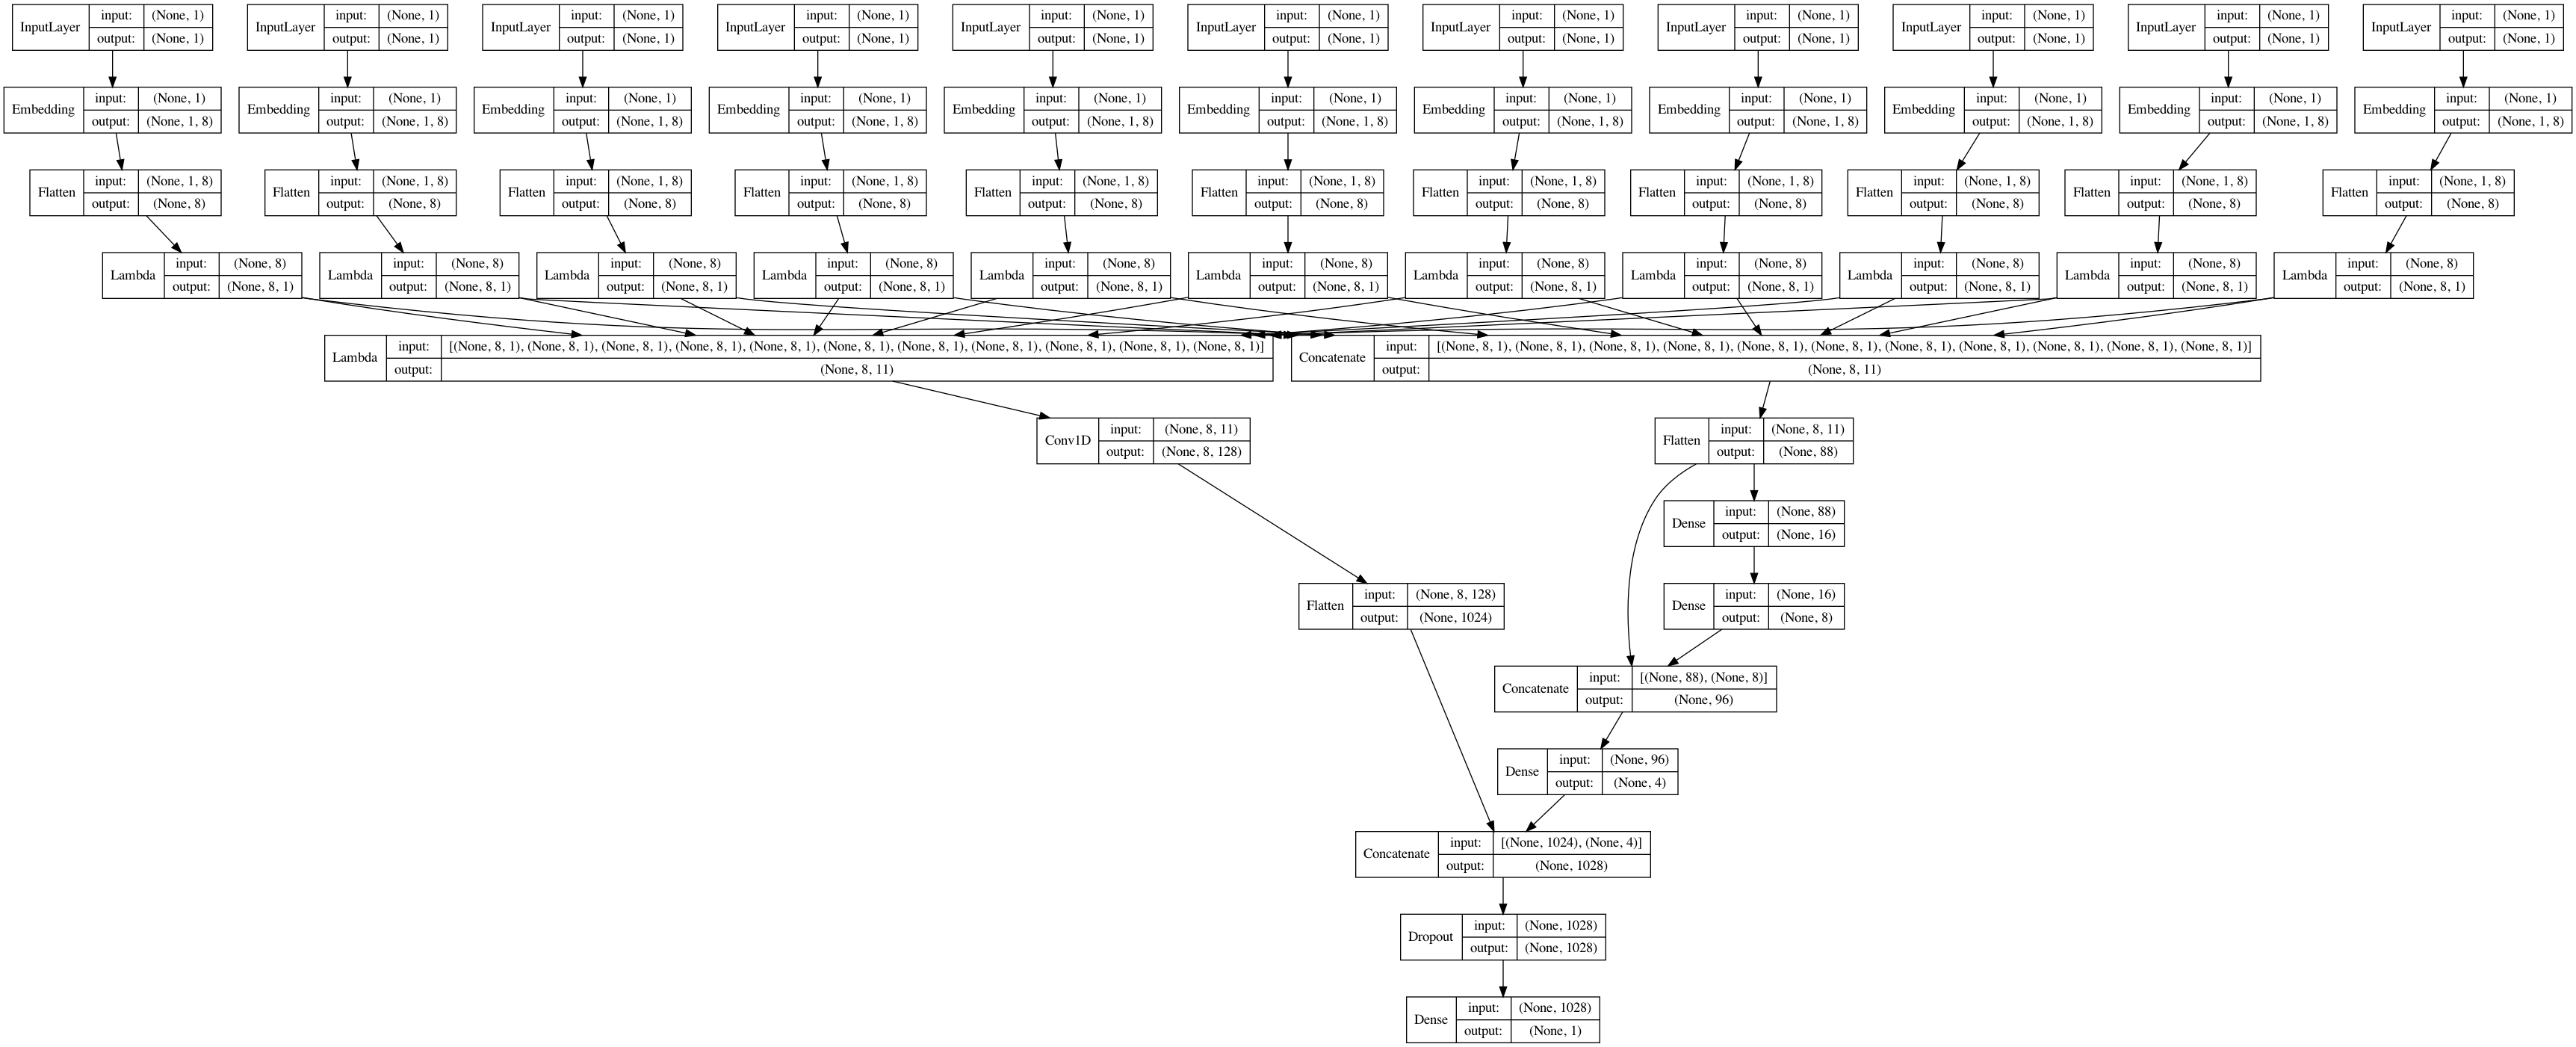

In [1241]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 93253 samples, validate on 469 samples
Epoch 1/20
93253/93253 [==============================] - 3s 34us/step - loss: 18.0593 - auc_20: 0.0000e+00 - val_loss: 13.9387 - val_auc_20: 0.0000e+00
Epoch 2/20
93253/93253 [==============================] - 2s 23us/step - loss: 17.2395 - auc_20: 0.0000e+00 - val_loss: 13.1300 - val_auc_20: 0.0000e+00
Epoch 3/20
93253/93253 [==============================] - 2s 24us/step - loss: 16.2119 - auc_20: 0.0000e+00 - val_loss: 12.0995 - val_auc_20: 0.0000e+00
Epoch 4/20
93253/93253 [==============================] - 2s 24us/step - loss: 14.9219 - auc_20: 0.0000e+00 - val_loss: 10.8381 - val_auc_20: 0.0000e+00
Epoch 5/20
93253/93253 [==============================] - 2s 21us/step - loss: 13.3681 - auc_20: 0.0000e+00 - val_loss: 9.3720 - val_auc_20: 0.0000e+00
Epoch 6/20
93253/93253 [==============================] - 2s 22us/step - loss: 11.5867 - auc_20: 0.0000e+00 - val_loss: 7.7410 - val_auc_20: 0.0000e+00
Epoch 7/20
93253/93253 [============

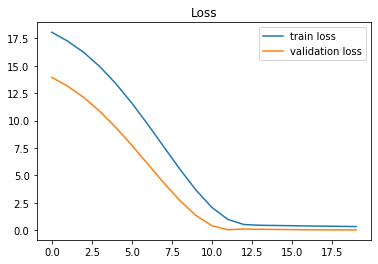

In [1242]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=global_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [1243]:
# # 모델 저장하기 
# model.save_weights(os.path.join("..","realtime_model",'wnd_global_model2.h5'))

# model_json = model.to_json()
# with open(os.path.join("..","realtime_model","wnd_global_model2.json"), "w") as json_file : 
#     json_file.write(model_json)
    
# print("Saved model to disk")

Saved model to disk


# item 유사도 반환

In [1244]:
# # 모델 불러오기 
# from keras.models import model_from_json 
# json_file = open(os.path.join("..","realtime_model","wnd_global_model2.json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join("..","realtime_model","wnd_global_model2.h5"))
# print("Loaded model from disk")

Loaded model from disk


In [1245]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [1256]:
vec = latent_to_vec('FM_locationId', model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [1249]:
vecs2 = pd.read_csv(os.path.join("..","realtime_model",'wnd_global_vec.csv'))
vecs2 = vecs2.rename(columns={'Unnamed: 0':'locationId'})
vecs2.to_csv(os.path.join("..","realtime_model",'wnd_global_vec.csv'))#, index=False)

vecs2

In [834]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [835]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [662]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 오리지널팬케이크하우스
  주소 서울 강남구 강남대로162길 41
top 2 시그니엘 서울 더 라운지
  주소 서울 송파구 올림픽로 300 롯데월드타워 79층
top 3 영월
  주소 서울 서대문구 연희로 81-21
top 4 뱃고동
  주소 서울 강남구 언주로172길 54
top 5 샤이바나 - 광화문
  주소 서울 중구 세종대로 136
top 6 진고개
  주소 서울 충무로3가 30-16
top 7 장원각
  주소 서울 동호로 233-3
top 8 매화반점
  주소 서울 광진구 자양4동 4-11
top 9 곳간
  주소 서울 영등포구 여의대로 24 전경련회관 50층
top 10 모리
  주소 서울 서대문구 대현동 37-3


In [617]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [663]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 카페엣모스피어‬
  주소 서울 마포구 망원로 54-1
top 2 수연 산방
  주소 서울 성북구 성북동 248
top 3 빕스 명동중앙점
  주소 서울 중구 명동길 53
top 4 도셰프 논현점
  주소 서울 서초구 반포동 707-8
top 5 커피스미스
  주소 서울 강남대로92길 13
top 6 좋은세상만들기
  주소 서울 양평로12가길 14
top 7 불고기 브라더스 서울 파이낸스 센터점
  주소 서울 중구 태평로 1가 84번지 서울파이낸스센터 지하 2층 3호
top 8 톡톡
  주소 서울 강남구 도산대로51길 33 3층
top 9 고에몬
  주소 서울 서초대로77길 7
top 10 까페 마마스 시청점
  주소 서울 중구 무교동 19


In [664]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 카페큐브 한옥카페
  주소 서울 중구 남대문로 11
top 2 모찌
  주소 서울 용산구 우사단로14길 11 ITW 호텔 1층
top 3 이품왕손만두
  주소 서울 성미산로 184
top 4 코리안덕
  주소 서울 명동10길 7
top 5 오프레
  주소 서울 서울 서초구 반포대로4길 12
top 6 밀크홀1937 - 종로점
  주소 서울 종로구 종로 86-1
top 7 단풍나무집 - 이태원점
  주소 서울 용산구 이태원로27가길 26
top 8 하카다분코
  주소 서울 마포구 독막로19길 43
top 9 앨리스 청담
  주소 서울 강남구 도산대로55길 47 지하1층
top 10 오스테리아꼬또
  주소 서울 종로 33


In [665]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 마포갈비
  주소 서울 서초대로75길 36
top 2 슌미
  주소 서울 강남구 봉은사로 130 노보텔 앰배서더 서울 강남 LL층
top 3 맥파이 - 이태원점
  주소 서울 용산구 녹사평대로 244-1
top 4 신선설농탕 홍대점
  주소 서울 마포구 양화로 136
top 5 차이나팩토리
  주소 서울 강남대로 309
top 6 카페베네 공덕역점
  주소 서울 마포구 공덕동 423번지 b2호
top 7 곰국시집
  주소 서울 무교동 12-1
top 8 뚜레쥬르
  주소 서울 신흥로 89
top 9 서브웨이
  주소 서울 퇴계로 204
top 10 만랩커피 역삼래미안점
  주소 서울 강남구 선릉로69길 19 역삼래미안상가 1층 110호


In [666]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 놀부 홍대점
  주소 서울 마포구 서교동 354-2
top 2 맥도날드 관훈점
  주소 서울 종로구 관훈동 198-42
top 3 창화당 - 익선동
  주소 서울 종로구 수표로28길 23
top 4 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울 종로구 청계천로 279 JW 메리어트 동대문 스퀘어 서울 LL 층
top 5 이니스프리 그린카페
  주소 서울 중구 명동길 13
top 6 에피세리꼴라주
  주소 서울 한남대로20길 47-24
top 7 라따블
  주소 서울 중구 남대문로 78 이비스 앰배서더 서울 명동 19층
top 8 최대감네
  주소 서울 종로구 경운동 64-47 지상1층 1f
top 9 더심플한테이블
  주소 서울 독막로5길 32
top 10 송원
  주소 서울 중구 장충동2가 188-3


In [667]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 툭툭누들타이
  주소 서울 연희로 37
top 2 스타벅스 신촌점
  주소 서울 서대문구 창천동 18-55 즐거운 빌딩 1,2,3F Jeulgeoun Building 1,2,3F
top 3 진진바라 서초점
  주소 서울 서초구 서초대로 254 오퓨런스빌딩 B2
top 4 요수정
  주소 서울 광성로 28
top 5 자코비 버거
  주소 서울 용산구 용산동2가 45-6
top 6 호아빈
  주소 서울 명동7가길 20
top 7 르빵
  주소 서울 백제고분로41길 12
top 8 뜨리앙
  주소 서울 강남구 도산대로67길 30
top 9 붓처스컷 광화문점
  주소 서울 중구 세종대로 136
top 10 스시조
  주소 서울 소공로 106


추천 받아 의미없을 '맥도날드'와 같은 글로벌 체인 제거 (이또한, 휴리스틱)

In [836]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 자연별곡 - 신촌점
  주소 서울 마포구 신촌로 94 그랜드플라자 6층
top 2 더키친살바토레앤바
  주소 서울 율곡로2길 7 서머셋 팰리스 서울 1층
top 3 디스틸
  주소 서울 와우산로15길 10
top 4 아웃백스테이크하우스 센트럴시티점
  주소 서울 서울 서초구 반포동 19-3
top 5 호남식당
  주소 서울 퇴계로41길 9
top 6 한순자손칼국수
  주소 서울 남대문시장4길 39
top 7 나루 가온
  주소 서울 광진구 아차산로78길 75,
top 8 트래블메이커
  주소 서울 마포구 양화로21길 37
top 9 토속촌삼계탕
  주소 서울 종로구 자하문로5길 5
top 10 The View
  주소 서울 21, Gwangjang-dong, Gwangjin-gu


In [837]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [838]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 맥도날드 강남점
  주소 서울 강남구 역삼동 816
top 2 맥파이 - 이태원점
  주소 서울 용산구 녹사평대로 244-1
top 3 어바웃진스 바베큐 키친
  주소 서울 종로구 새문안로3길 30 대우빌딩 지하1층 106호
top 4 청진식당
  주소 서울 종로구 종로11길 6
top 5 왓어샐러드
  주소 서울 용산구 보광로59길 31
top 6 미미네 - 홍대본점
  주소 서울 마포구 잔다리로 2길 24
top 7 뚜레쥬르
  주소 서울 남대문로 30
top 8 할머니 칼국수
  주소 서울 종로구 돈의동 49-1
top 9 힛더스팟 삼청점
  주소 서울 종로구 북촌로5길 74
top 10 피트 카페
  주소 서울 구로구 경인로 662 쉐라톤 서울 디큐브 시티 호텔 28F


In [839]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 모리샤브하우스
  주소 서울 난계로 201
top 2 마복림 원조 할머니집 떡볶이
  주소 서울 중구 신당1동 292-112
top 3 종로설렁탕
  주소 서울 종로46길 22
top 4 한방삼계탕
  주소 서울 강남구 역삼1동 831-18
top 5 양반댁
  주소 서울 종로구 인사동길 19-18
top 6 정선할매 곤드레밥
  주소 서울 종로구 인사동8길 13
top 7 리틀파파2호점
  주소 서울 와우산로27길 24
top 8 오프레
  주소 서울 서울 서초구 반포대로4길 12
top 9 카페베네 명동세종호텔점
  주소 서울 중구 충무로2가 12-27
top 10 올라 여의도 파크센터점
  주소 서울 영등포구 여의대로 8 여의도파크센터 지하1층


In [840]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 치킨인더키친 홍대본점
  주소 서울 마포구 와우산로29길 4-42
top 2 스타벅스 소공동점
  주소 서울 중구 소공로 106 서울 웨스틴조선호텔
top 3 슌미
  주소 서울 강남구 봉은사로 130 노보텔 앰배서더 서울 강남 LL층
top 4 훅트포케
  주소 서울 서울 중구 삼일대로12길 18
top 5 던킨 도너츠 서울역1호
  주소 서울 405, Hangang-daero, Jung-gu 지하1층
top 6 그라노
  주소 서울 강남구 신사동 645-1번지 1층
top 7 원조마포 할머니빈대떡
  주소 서울 마포구 공덕동 256-30
top 8 서울커피
  주소 서울 남부순환로 1949
top 9 도스타코스 정동점
  주소 서울 중구 서소문로11길 19 배재정동빌딩 A동 LL층
top 10 동화반점
  주소 서울 중구 장충단로13길 7


In [841]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 봉평메밀면사무소
  주소 서울 성동구 왕십리로5길 9-20
top 2 원조할머니 떡볶이집
  주소 서울 종로구 자하문로15길 13
top 3 스타벅스 고대점
  주소 서울 성북구 안암동5가 104-30
top 4 오스테리아꼬또
  주소 서울 종로 33
top 5 왕비집 종로점
  주소 서울 종로구 삼일대로15길 24
top 6 장수갈비집
  주소 서울 중구 명동2길 54-1
top 7 아웃백 코엑스점
  주소 서울 강남구 삼성동 159 오크우드호텔 B2층
top 8 Parmi Italiano
  주소 서울 Shinchon
top 9 스시효
  주소 서울 동호로 287
top 10 피스트
  주소 서울 구로구 경인로 662 쉐라톤 서울 디큐브 시티 호텔 41F


In [842]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 태극당
  주소 서울 중구 동호로24길 7
top 2 미스터케밥
  주소 서울 용산구 이태원로 192
top 3 프리미엄애슐리 강변점
  주소 서울 광진구 구의동546-4  테크노마트 9층 9F, Techno Mart
top 4 투뿔 강남역점
  주소 서울 강남구 테헤란로4길 6 센트럴애비뉴 2층
top 5 향미
  주소 서울 중구 명동2가 106
top 6 라이언카페
  주소 서울 서초구 강남대로 429 카카오프렌즈 강남 3층
top 7 성천막국수
  주소 서울 동대문구 전농로 48
top 8 신촌수제비
  주소 서울 신촌로 87-8
top 9 스노브
  주소 서울 마포구 와우산로 59-1
top 10 스타벅스 수송동점
  주소 서울 종로구 수송동 51-8 G 타워 1F G Tower 1F
